In [1]:
import outlaw.nb_util
outlaw.nb_util.setup_nb()
import numpy as np
import matplotlib.pyplot as plt
import scipy.spatial
import scipy.special
import berrylib.grid as berrylibgrid
import berrylib.binomial

grid_info, sim_info, bound_info = np.load('output_berry3d.npy', allow_pickle=True)

(theta, theta_tiles, tile_radii, corners, null_truth) = grid_info
(sim_sizes, typeI_sum, typeI_score) = sim_info
(total_gp, d0_gp, d0u_gp, d1w_gp, d1uw_gp, d2uw_gp) = bound_info

In [2]:
n_arms = theta_tiles.shape[1]
n_arm_samples = 35
null_hypos = [
    berrylibgrid.HyperPlane(-np.identity(n_arms)[i], -scipy.special.logit(0.1)) for i in range(n_arms)
]
tree = scipy.spatial.KDTree(theta_tiles)

def eval_bound(eval_pts):
    dist, idx = tree.query(eval_pts, k=2 ** n_arms)
    tile_idx = np.full(eval_pts.shape[0], -1, dtype=int)
    eval_null = np.empty((eval_pts.shape[0], len(null_hypos)), dtype=bool)
    for d, H in enumerate(null_hypos):
        boundary_dist = eval_pts.dot(H.n) - H.c
        eval_null[:, d] = boundary_dist >= 0
    for i in range(2 ** n_arms):
        # We choose a tile if the hypotheses all match and the tile has not
        # been assigned yet. The result is that an evaluation point is assigned
        # to the tile it is closest to that matches all hypotheses.
        select = (null_truth[idx[:, i]] == eval_null).all(axis=1) & (tile_idx == -1)
        tile_idx[select] = idx[select, i]
    # assert(np.all((null_truth[tile_idx] == eval_null).all(axis=1)))
    reduced_tile_idx = tile_idx[tile_idx != -1]

    out_arrs = berrylib.binomial.upper_bound(
        theta_tiles[reduced_tile_idx],
        tile_radii[reduced_tile_idx],
        eval_pts[tile_idx != -1, None, :],
        sim_sizes[reduced_tile_idx],
        n_arm_samples,
        typeI_sum[reduced_tile_idx],
        typeI_score[reduced_tile_idx]
    )
    full_out_arrs = []
    for a in out_arrs:
        a_full = np.full(eval_pts.shape[0], np.nan)
        a_full[tile_idx != -1] = a
        full_out_arrs.append(a_full)
    return full_out_arrs

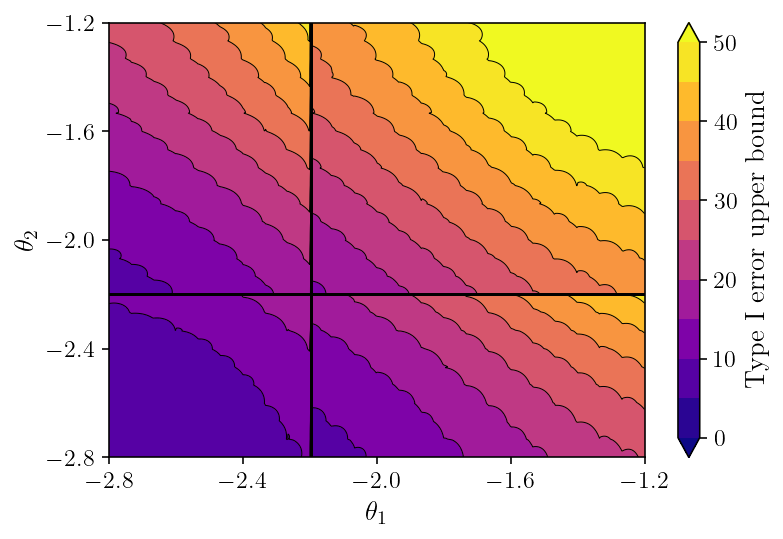

In [3]:


def set_domain(cbar_target, skipx=False, skipy=False, cbar=True, cbar_label=True):
    if cbar:
        cbar = plt.colorbar(cbar_target)
        if cbar_label:
            cbar.set_label("Type I error upper bound")
    if skipx:
        plt.tick_params(
            axis="x", which="both", bottom=False, top=False, labelbottom=False
        )

    else:
        plt.xlabel(r"$\theta_1$")
        plt.xticks(np.linspace(-2.8, -1.2, 5))
    if skipy:
        plt.tick_params(
            axis="y", which="both", left=False, right=False, labelleft=False
        )
    else:
        plt.ylabel(r"$\theta_2$")
        plt.yticks(np.linspace(-2.8, -1.2, 5))
    plt.axvline(x=scipy.special.logit(0.1), color="k", linestyle="-")
    plt.axhline(y=scipy.special.logit(0.1), color="k", linestyle="-")


def fig1(cmap=None, n_contours=11, **kwargs):
    t0 = scipy.special.logit(0.1) - 0.001
    n1 = 500
    n2 = n1
    t1 = np.linspace(-2.8, -1.2, n1)
    t2 = np.linspace(-2.8, -1.2, n2)
    t12 = np.stack(np.meshgrid(t1, t2, indexing="ij"), axis=-1)
    eval_pts = np.concatenate([np.full((n1, n2, 1), t0), t12], axis=-1)
    eval_pts = eval_pts.reshape((-1, n_arms))

    bound = eval_bound(eval_pts)

    eval_pts_3d = eval_pts.reshape((n1, n2, 3))
    simple_slice(eval_pts_3d, bound)

def simple_slice(eval_pts_3d, bound, cmap=None, n_contours=11, **kwargs):
    n1, n2 = eval_pts_3d.shape[:2]

    x = eval_pts_3d[:, :, 1]
    y = eval_pts_3d[:, :, 2]
    z = bound[0].reshape((n1, n2))
    levels = np.linspace(0, 50, n_contours)

    cbar_target = plt.contourf(x, y, z * 100, levels=levels, extend="both", cmap=cmap)
    plt.contour(
        x,
        y,
        z * 100,
        levels=levels,
        colors="k",
        linestyles="-",
        linewidths=0.5,
        extend="both",
    )
    set_domain(cbar_target, **kwargs)


fig1()
plt.show()

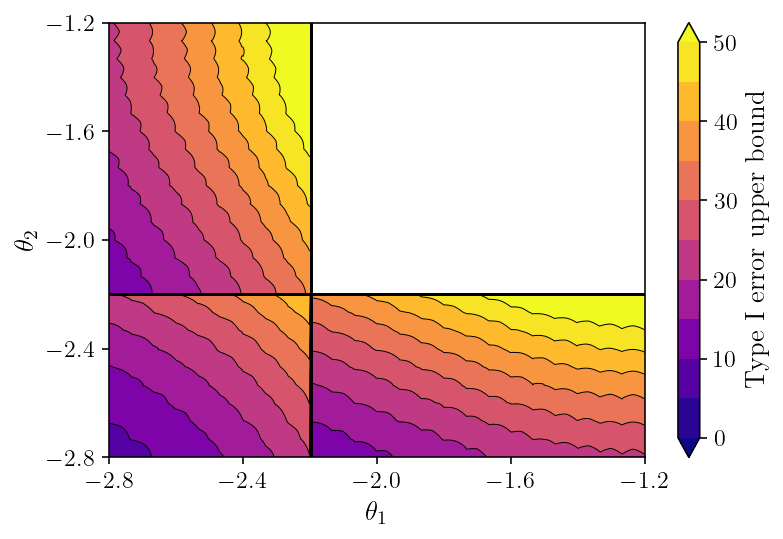

In [4]:
max_theta = theta_tiles[np.argmax(total_gp),:]
def fig2(cmap=None, n_contours=11, **kwargs):
    t0 = max_theta[0]
    n1 = 500
    n2 = n1
    t1 = np.linspace(-2.8, -1.2, n1)
    t2 = np.linspace(-2.8, -1.2, n2)
    t12 = np.stack(np.meshgrid(t1, t2, indexing="ij"), axis=-1)
    eval_pts = np.concatenate([np.full((n1, n2, 1), t0), t12], axis=-1)
    eval_pts = eval_pts.reshape((-1, n_arms))
    
    bound = eval_bound(eval_pts)

    eval_pts_3d = eval_pts.reshape((n1, n2, 3))
    simple_slice(eval_pts_3d, bound, **kwargs)
fig2()
plt.show()

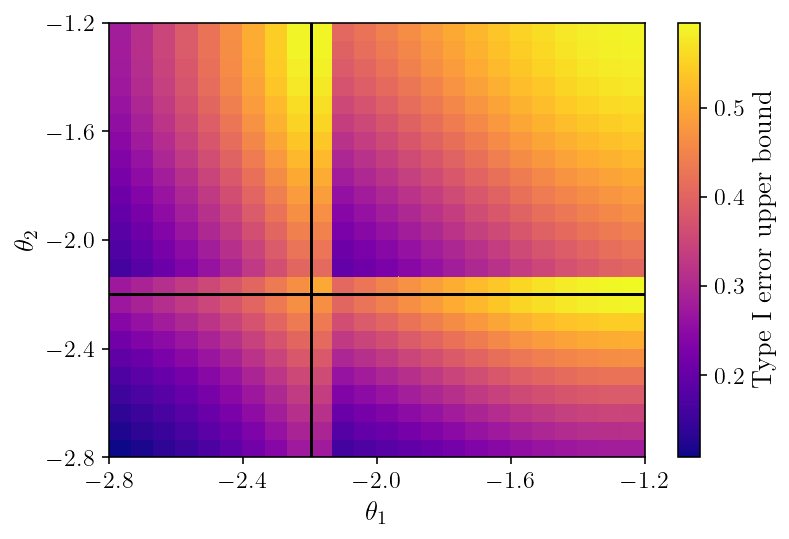

In [5]:
def fig3(**kwargs):
    t2_unique = np.unique(theta_tiles[:,2])
    t1t2_pts = []
    worst_bound = []
    worst_theta = []
    for t1 in t2_unique:
        for t2 in t2_unique:
            select = (theta_tiles[:,1] == t1) & (theta_tiles[:,2] == t2)
            worst_idx = np.argmax(total_gp[select])
            worst_theta.append(theta_tiles[select][worst_idx])
            t1t2_pts.append((t1, t2))
            worst_bound.append(total_gp[select][worst_idx])

    grid_shape = t2_unique.shape[0], t2_unique.shape[0]
    t1t2_pts = np.array(t1t2_pts).reshape((*grid_shape, 2))
    worst_bound = np.array(worst_bound).reshape(grid_shape)
    worst_theta = np.array(worst_theta).reshape((*grid_shape, 3))

    cbar_target = plt.pcolor(t1t2_pts[...,0], t1t2_pts[...,1], worst_bound)
    set_domain(cbar_target, **kwargs)
fig3()
plt.show()
# cbar_target = plt.tripcolor(t1t2_pts[...,0].ravel(), t1t2_pts[...,1].ravel(), worst_bound.ravel())

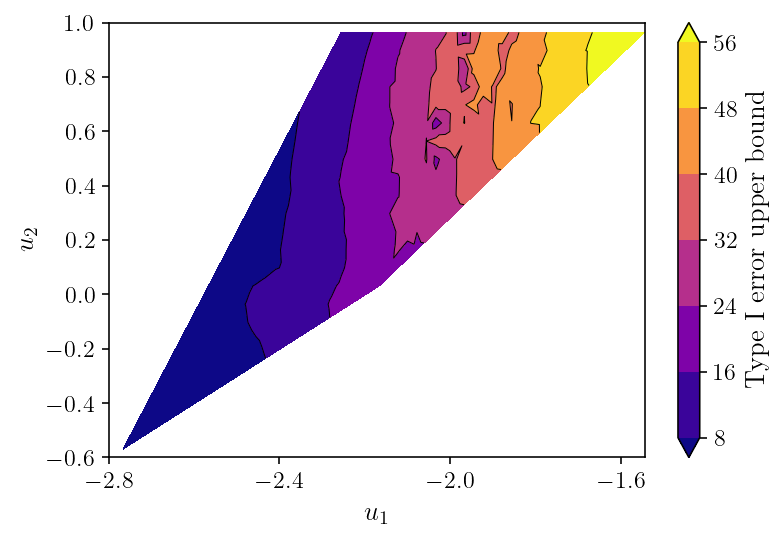

In [6]:
def fig4(skipx=False, skipy=False):

    u1s = theta_tiles.sum(axis=-1) / n_arms
    u2s_idx = np.argmax(theta_tiles - scipy.special.logit(0.1), axis=-1)
    u2s = (theta_tiles[np.arange(theta_tiles.shape[0]), u2s_idx] - scipy.special.logit(0.1))
    u1u2_pts = []
    worst_bound = []
    for u1v in np.unique(u1s):
        u1_select = u1s == u1v
        for u2v in np.unique(u2s[u1_select]):
            select = (u1s == u1v) & (u2s == u2v)
            worst_idx = np.argmax(total_gp[select])
            worst_theta = theta_tiles[select][worst_idx]
            u1u2_pts.append((u1v, u2v))
            worst_bound.append(total_gp[select][worst_idx])
    u1u2_pts = np.array(u1u2_pts)
    worst_bound = np.array(worst_bound)

    x = u1u2_pts[..., 0]
    y = u1u2_pts[..., 1]
    z = worst_bound
    levels = None
    cbar_target = plt.tricontourf(x, y, z * 100, levels=levels, extend="both")
    plt.tricontour(
        x,
        y,
        z * 100,
        levels=levels,
        colors="k",
        linestyles="-",
        linewidths=0.5,
        extend="both",
    )
    cbar = plt.colorbar(cbar_target)
    cbar.set_label('Type I error upper bound')
    if skipx:
        plt.tick_params(
            axis="x", which="both", bottom=False, top=False, labelbottom=False
        )

    else:
        plt.xlabel(r'$u_1$')
        plt.xticks(np.linspace(-2.8, -1.6, 4))
    if skipy:
        plt.tick_params(
            axis="y", which="both", left=False, right=False, labelleft=False
        )
    else:
        plt.ylabel(r'$u_2$')
        plt.yticks(np.linspace(-0.6, 1.0, 9))
fig4()
plt.show()

\begin{align}
u_1 &= (\theta_1 + \theta_2 + \theta_3 + \theta_4)/4.0\\
u_2 &= max(\theta_i - logit(p_1))
\end{align}

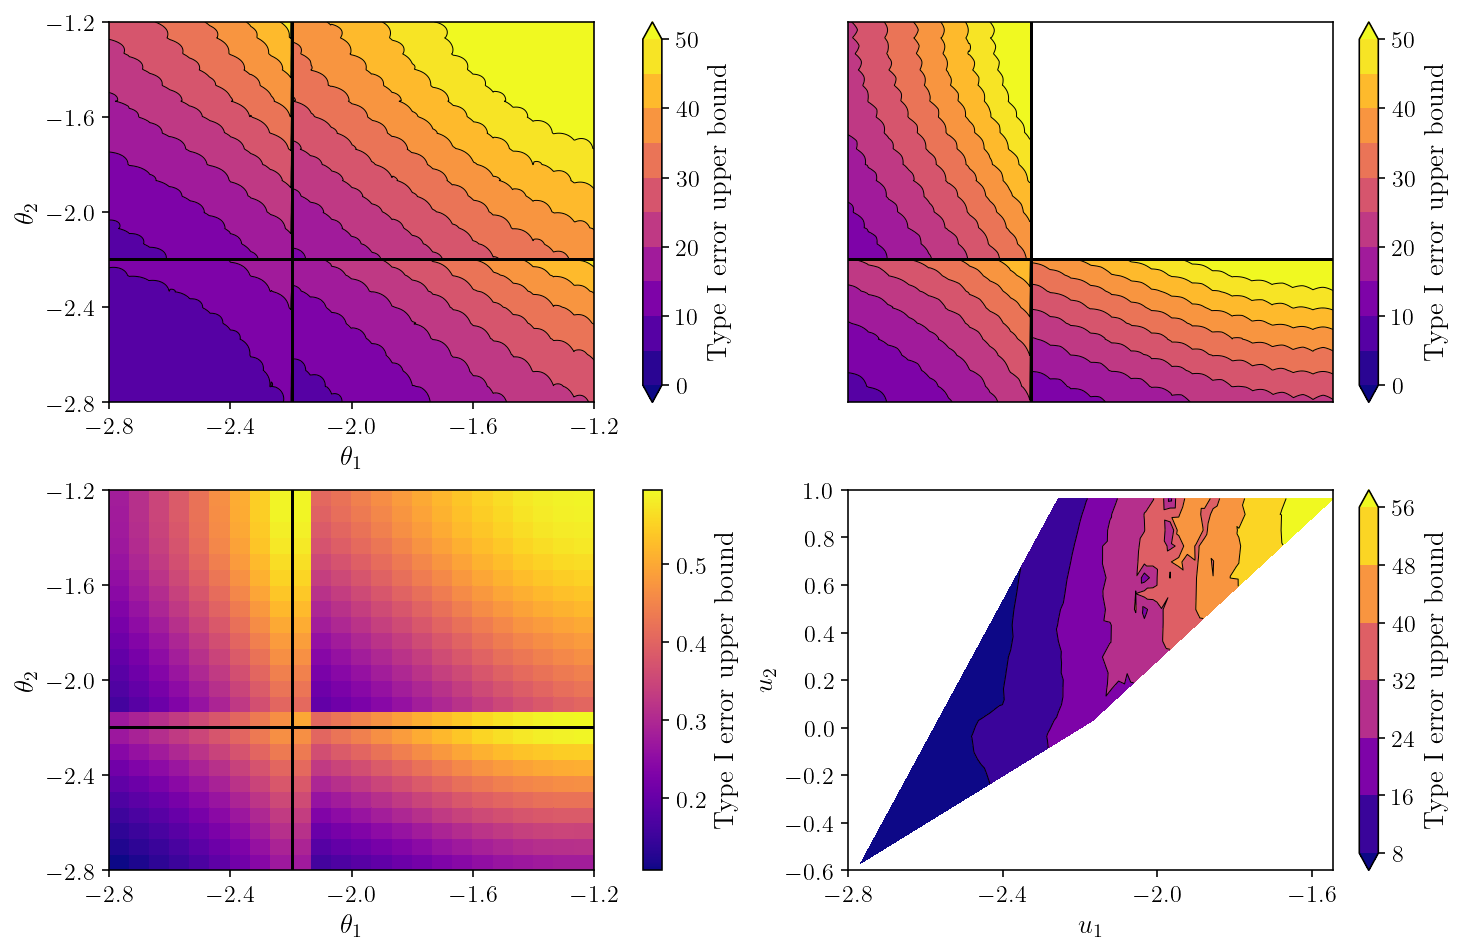

In [7]:
ratio = 8.5 / 5.5
h = 6.5
plt.figure(figsize=(ratio * h, h), constrained_layout=True)
plt.subplot(2,2,1)
fig1()
plt.subplot(2,2,2)
fig2(skipx=True, skipy=True)
plt.subplot(2,2,3)
fig3()
plt.subplot(2,2,4)
fig4()

plt.show()